In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G
from astropy import units as u
from scipy.integrate import quad
import symlib
import os
from glob import glob

In [5]:
def density_profile(base_dir, suite_name, output_dir, snap, n_bins=40, r_min=0.001, r_max=1.5):
    """
    Measure the density profile of each host halo in a suite at a given snapshot,
    and save the profile as a pandas DataFrame (columns: halo_idx, r_scaled, rho_scaled).
    Optionally compute and return mean halo concentration and virial mass.

    Parameters
    ----------
    base_dir : str
        Root directory of the simulation suite containing all halo data.
    
    suite_name : str
        Name of the simulation suite (e.g., 'SymphonyLMC').

    snap : int
        Snapshot number to read particle data from.

    n_bins : int
        Number of logarithmic radial bins used for density profile computation.

    r_min : float
        Minimum radius (in units of R_vir) for the radial binning range.

    r_max : float
        Maximum radius (in units of R_vir) for the radial binning range.

    """
    # Read basic simulation parameters
    n_halos = symlib.n_hosts(suite_name)
    params = symlib.simulation_parameters(suite_name)
    h = params['h100']
    mp = params['mp'] / h  # Particle mass [Msun]
    eps = params['eps'] / h  # Softening length [kpc]
    H0 = params["H0"]  # Hubble constant [km/s/Mpc]
    Om0 = params["Om0"]  # Matter density parameter

    # Compute background matter density rho_m = Omega_m * rho_crit
    H0_si = params["H0"] * u.km / u.s / u.Mpc
    G_si = G.to(u.Mpc**3 / u.Msun / u.s**2)
    rho_crit = (3 * H0_si**2 / (8 * np.pi * G_si)).to(u.Msun / u.kpc**3).value
    rho_m = Om0 * rho_crit
    print(f'Om0={Om0}')

    cvir = []
    mvir = []
    
    for halo_idx in range(n_halos):
        # Get path to the current halo
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)
        
        try:
            # Read Rockstar halo catalog
            r, hist = symlib.read_rockstar(sim_dir)
            host = r[0, -1]
        except FileNotFoundError:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}")
            continue

        center = host['x'][-1]   # Halo center position
        r_vir = host['rvir']     # Virial radius [kpc]


        cvir_val = host['cvir']
        cvir.append(cvir_val)
        mvir_val = host['m']
        mvir.append(mvir_val)

        # Read particle snapshot
        part = symlib.Particles(sim_dir)
        try:
            p = part.read(snap)
        except FileNotFoundError:
            print(f"[Warning] Particle snapshot not found for Halo {halo_idx}")
            continue

        # Compute radial distances from halo center
        x = p[0]['x']
        dx = x - center
        radi = np.linalg.norm(dx, axis=1)
        radi_scaled = radi / r_vir

        # Create logarithmic radial bins
        bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        # Compute mass in each spherical shell
        counts, _ = np.histogram(radi_scaled, bins=bins)
        shell_volumes = (4/3) * np.pi * ((bins[1:] * r_vir)**3 - (bins[:-1] * r_vir)**3)
        mass_per_bin = counts * mp
        rho = mass_per_bin / shell_volumes  # Density [Msun/kpc^3]
        rho_scaled = rho / rho_m            # Scaled by background density

        # Save density profile to CSV
        df = pd.DataFrame({
            "halo_idx": halo_idx,
            "r_scaled": bin_centers,
            "rho_scaled": rho_scaled
        })

        out_path = f"{output_dir}/output/{suite_name}/density_profiles"
        os.makedirs(out_path, exist_ok=True)
        df.to_csv(f"{out_path}/halo_{halo_idx:03d}_profile.csv", index=False)

        print(f"[Saved] {suite_name} Halo {halo_idx:03d} density profile saved.")

    # Return mean concentration and mass across halos
    mean_cvir = np.mean(cvir)
    mean_mvir = np.mean(mvir)
    print(f'mean cvir of {suite_name} is: {mean_cvir}, mean mvir is: {mean_mvir}')

In [6]:
def plot_density(base_dir, suite_name, mean_cvir):
    """
    Plot individual and mean scaled density profiles (rho * r^2 vs r) for a halo suite.
    Optionally overlay a scaled NFW profile with the given concentration.
    """

    def nfw_density(c, r_scaled):
        f_c = np.log(1 + c) - c / (1 + c)
        x = r_scaled * c
        Om0 = 0.286  # Use consistent background matter density
        delta_c = (99 * c**3) / (3 * f_c)
        rho_scaled = delta_c / (x * (1 + x)**2) / Om0 
        return rho_scaled
    
    input_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
    file_list = sorted(glob(os.path.join(input_dir, "halo_*_profile.csv")))

    if not file_list:
        print("[Error] No profile files found.")
        return

    # -------- Load all halo profiles --------
    all_profiles = []
    for file in file_list:
        df = pd.read_csv(file)
        df["rho_r2"] = df["rho_scaled"] * df["r_scaled"]**2
        all_profiles.append(df)

    # Extract common radial binning (assumed the same for all halos)
    r_scaled = all_profiles[0]["r_scaled"].values
    rho_r2_all = np.array([df["rho_r2"].values for df in all_profiles])

    # -------- Plot 1: All halo profiles --------
    plt.figure(figsize=(6, 4), dpi=500)
    for rho_r2 in rho_r2_all:
        plt.loglog(r_scaled, rho_r2, alpha=0.3, linewidth=0.7)
    plt.xlabel(r"$r / r_{\mathrm{vir}}$")
    plt.ylabel(r"$(\rho/\bar{\rho}_m) \cdot (r/r_{\mathrm{vir}})^2$")
    plt.grid(True, which="both", ls=":")
    plt.title(f"Density Profiles ({suite_name})")
    plt.tight_layout()
    os.makedirs(f"{base_dir}/output/{suite_name}/figures", exist_ok=True)
    plt.savefig(f"{base_dir}/output/{suite_name}/figures/density_profiles.png")
    plt.show()
    plt.close()

    # -------- Plot 2: Mean + 1σ envelope + NFW --------
    mean_rho_r2 = np.mean(rho_r2_all, axis=0)
    std_rho_r2 = np.std(rho_r2_all, axis=0)

    plt.figure(figsize=(6, 4), dpi=500)
    plt.loglog(r_scaled, mean_rho_r2, color="orange", label="Mean Profile", linewidth=0.7)
    plt.fill_between(r_scaled, mean_rho_r2 - std_rho_r2, mean_rho_r2 + std_rho_r2,
                     color="orange", alpha=0.3, label=r"$\pm1\sigma$")

    # Overlay scaled NFW profile
    nfw_rho_r2 = nfw_density(mean_cvir, r_scaled) * r_scaled**2
    plt.loglog(r_scaled, nfw_rho_r2,
               linestyle='--', linewidth=0.7, color='black',
               label=f"NFW (c = {mean_cvir:.1f})")

    # Optional: plot extracted profile from external file
    # ext_df = pd.read_csv('/Volumes/Atlas/Symphony/figure6_LMC.csv')
    # plt.loglog(ext_df["r/R_vir_host"], ext_df["(r/R_vir)^2 rho/rho_m"],
    #            color="black", lw=2, label="Extracted LMC Profile")

    plt.xlabel(r"$r / r_{\mathrm{vir}}$")
    plt.ylabel(r"$(\rho/\bar{\rho}_m) \cdot (r/r_{\mathrm{vir}})^2$")
    plt.grid(True, which="both", ls=":")
    plt.title(f"Mean Density Profile ({suite_name})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{base_dir}/output/{suite_name}/figures/mean_density_profile.png")
    plt.show()
    plt.close()

    print(f"[Done] Plots saved to {base_dir}/output/{suite_name}/figures/")

In [7]:
def velocity_profile(base_dir, suite_name, output_dir, snap, n_bins=40, r_min=0.001, r_max=1.5):
    """
    Measure the radial, tangential, and total velocity dispersion profiles, as well as the velocity anisotropy profile,
    for each host halo in a simulation suite at a given snapshot. Results are saved per halo.
    """
    
    # Read halo count and cosmological/simulation parameters
    n_halos = symlib.n_hosts(suite_name)
    params = symlib.simulation_parameters(suite_name)
    h = params['h100']
    eps = params['eps'] * h  # kpc
    H0 = params["H0"]  # km/s/Mpc

    for halo_idx in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)

        # Load host halo data
        try:
            r, hist = symlib.read_rockstar(sim_dir)
            host = r[0, -1]
        except FileNotFoundError:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}")
            continue

        # Compute virial velocity
        center = host['x'][-1]         # Halo center [kpc]
        v_host = host['v'][-1]         # Halo bulk velocity [km/s]
        r_vir = host['rvir']           # Virial radius [kpc]
        m_vir = host['m']              # Virial mass [Msun]
        m = m_vir * u.Msun
        r = r_vir * u.kpc
        G_kpc = G.to(u.kpc * (u.km/u.s)**2 / u.Msun)
        v_vir = np.sqrt(G_kpc * m / r).to(u.km / u.s).value  # Virial velocity [km/s]

        # Load particle data
        part = symlib.Particles(sim_dir)
        try:
            p = part.read(snap)
        except FileNotFoundError:
            print(f"[Warning] Particle snapshot not found for Halo {halo_idx}")
            continue

        # Positions and velocities in host frame
        x = p[0]['x']  # positions [kpc]
        v = p[0]['v']  # velocities [km/s]
        dx = x - center
        dv = v - v_host
        radi = np.linalg.norm(dx, axis=1)
        radi_scaled = radi / r_vir

        # Decompose velocities: radial vs tangential
        r_hat = dx / radi[:, None]
        v_rad = np.sum(dv * r_hat, axis=1)
        v_tan = dv - v_rad[:, None] * r_hat

        # Set up logarithmic radial bins
        bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        # Containers for profiles
        sigma_rad_scaled = []
        sigma_tan_scaled = []
        sigma_total_scaled = []
        beta_profile = []

        # Compute statistics in each bin
        for i in range(n_bins):
            in_bin = (radi_scaled >= bins[i]) & (radi_scaled < bins[i + 1])

            # Radial velocity dispersion
            sigma_rad = np.std(v_rad[in_bin])
            sigma_rad_scaled.append(sigma_rad / v_vir)

            # Total velocity dispersion (quadrature of components)
            sigma_x = np.std(dv[in_bin][:, 0])
            sigma_y = np.std(dv[in_bin][:, 1])
            sigma_z = np.std(dv[in_bin][:, 2])
            sigma_total = np.sqrt(sigma_x**2 + sigma_y**2 + sigma_z**2)
            sigma_total_scaled.append(sigma_total / v_vir)

            if sigma_total < sigma_rad:  
                sigma_total = sigma_rad

            # Tangential dispersion (from subtraction)
            sigma_tan = np.sqrt(max(0, sigma_total**2 - sigma_rad**2))
            sigma_tan_scaled.append(sigma_tan / v_vir)

            # Velocity anisotropy beta = 1 - (sigma_tan^2) / (2 * sigma_rad^2)
            if sigma_rad == 0:
                beta = np.nan
            else:
                beta = 1 - sigma_tan**2 / (2 * sigma_rad**2)
            beta_profile.append(beta)

        # Save velocity profile for this halo
        df = pd.DataFrame({
            "halo_idx": halo_idx,
            "r_scaled": bin_centers,
            "sigma_rad_scaled": sigma_rad_scaled,
            "sigma_tan_scaled": sigma_tan_scaled,
            "sigma_total_scaled": sigma_total_scaled,
            "beta": beta_profile
        })

        out_path = f"{output_dir}/output/{suite_name}/velocity_profiles"
        os.makedirs(out_path, exist_ok=True)
        df.to_csv(f"{out_path}/halo_{halo_idx:03d}_profile.csv", index=False)

        print(f"[Saved] {suite_name} Halo {halo_idx:03d} velocity profile saved.")

In [8]:
def plot_velocity(base_dir, suite_name, mean_cvir):
    """
    Plot velocity dispersion (radial, tangential, total) and anisotropy (beta) profiles
    for all halos in a simulation suite. Compare them with the theoretical isotropic NFW solution.
    """

    def iso_nfw_velocity(c, x):
        g_c = 1 / (np.log(1 + c) - c / (1 + c))

        def integrand(t):
            g_t = np.log(1+t)-t/(1+t)
            return g_t / (t**3 * (1 + t)**2)

        integral, _ = quad(integrand, x, np.inf)
        sigma_r2_scaled = g_c * c * x * (1+x)**2 * integral

        return np.sqrt(sigma_r2_scaled)
    
    # Define input directories
    input_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")

    # Collect all halo velocity profile files
    files = sorted([f for f in os.listdir(input_dir) if f.endswith(".csv")])
    if not files:
        print("[Error] No CSV files found for velocity profiles.")
        return

    # Load data arrays for all halos
    r = pd.read_csv(os.path.join(input_dir, files[0]))["r_scaled"].values
    sigma_rad_all = np.array([pd.read_csv(os.path.join(input_dir, f))["sigma_rad_scaled"].values for f in files])
    sigma_tan_all = np.array([pd.read_csv(os.path.join(input_dir, f))["sigma_tan_scaled"].values for f in files])
    sigma_total_all = np.array([pd.read_csv(os.path.join(input_dir, f))["sigma_total_scaled"].values for f in files])
    beta_all = np.array([pd.read_csv(os.path.join(input_dir, f))["beta"].values for f in files])

    # =====================
    # Generate subplots
    # =====================
    fig, axes = plt.subplots(4, 2, figsize=(12, 10), sharex=True, dpi=500)
    titles = [r"$\sigma_{\mathrm{rad}} / V_{\mathrm{vir}}$", 
              r"$\sigma_{\mathrm{tan}} / V_{\mathrm{vir}}$",
              r"$\sigma_{\mathrm{total}} / V_{\mathrm{vir}}$",
              r"$\beta$"]
    data_arrs = [sigma_rad_all, sigma_tan_all, sigma_total_all, beta_all]
    colors = ["C0", "C1", "C2", "C3"]

    sigma_rad_nfw = np.array([iso_nfw_velocity(c=mean_cvir, x=ri*mean_cvir) for ri in r])
    sigma_tan_nfw = np.sqrt(2) * sigma_rad_nfw
    sigma_total_nfw = np.sqrt(3) * sigma_rad_nfw
    beta_nfw = np.zeros_like(r)
    nfw_profiles = [sigma_rad_nfw, sigma_tan_nfw, sigma_total_nfw, beta_nfw]

    for i in range(4):
        flat_data = data_arrs[i][~np.isnan(data_arrs[i])]

        if flat_data.size > 0:
            y_min = np.percentile(flat_data, 0.5)
            y_max = np.percentile(flat_data, 99.5)
        else:
            y_min, y_max = np.nan, np.nan

        y_pad = 0.05 * (y_max - y_min)

        # Left panel: all halo curves
        for arr in data_arrs[i]:
            axes[i, 0].plot(r, arr, color=colors[i], alpha=0.3, label='')
        axes[i, 0].plot(r, nfw_profiles[i], 'k--', lw=0.7,)
        axes[i, 0].set_ylabel(titles[i])
        axes[i, 0].set_xscale("log")
        axes[i, 0].set_ylim(y_min - y_pad, y_max + y_pad)
        axes[i, 0].grid(True, which="both", linestyle=":")


        # Right panel: mean ± 1σ + theory
        mean = np.nanmean(data_arrs[i], axis=0)
        std = np.nanstd(data_arrs[i], axis=0)
        axes[i, 1].plot(r, mean, color=colors[i], lw=1, label='Mean')
        axes[i, 1].fill_between(r, mean - std, mean + std, color=colors[i], alpha=0.3,label=r"$\pm1\sigma$")
        axes[i, 1].plot(r, nfw_profiles[i], 'k--', lw=1, label='Isotropic NFW')
        axes[i, 1].set_ylabel(titles[i])
        axes[i, 1].set_xscale("log")
        axes[i, 1].set_ylim(y_min - y_pad, y_max + y_pad)
        axes[i, 1].grid(True, which="both", linestyle=":")
        if i == 0:
            axes[i, 1].legend(loc='best', frameon=False)

    # X-axis labels
    axes[3, 0].set_xlabel(r"$r / r_{\mathrm{vir}}$")
    axes[3, 1].set_xlabel(r"$r / r_{\mathrm{vir}}$")

    fig.suptitle(f"Velocity Dispersion Profiles ({suite_name})", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    fig.savefig(f"{base_dir}/output/{suite_name}/figures/velocity_profiles.png")
    plt.show()
    plt.close(fig)

    print(f"[Done] Plots saved to {base_dir}/output/{suite_name}/figures/")

In [9]:

def mass_profile(base_dir, suite_name, output_dir, snap, n_bins=40, r_min=0.001, r_max=1.5):
    """
    Compute and save the enclosed mass profile for each host halo,
    and plot all profiles together on a single figure.
    """

    # Simulation parameters
    n_halos = symlib.n_hosts(suite_name)
    params = symlib.simulation_parameters(suite_name)
    h = params['h100']
    mp = params['mp'] / h
    eps = params['eps'] / h

    # Prepare storage for all profiles
    all_r_scaled = []
    all_m_scaled = []

    for halo_idx in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)

        try:
            r, hist = symlib.read_rockstar(sim_dir)
            host = r[0, -1]
        except FileNotFoundError:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}")
            continue

        center = host['x'][-1]
        m_vir = host['m']
        r_vir = host['rvir']

        part = symlib.Particles(sim_dir)
        try:
            p = part.read(snap)
        except FileNotFoundError:
            print(f"[Warning] Particle snapshot not found for Halo {halo_idx}")
            continue

        x = p[0]['x']
        dx = x - center
        radi = np.linalg.norm(dx, axis=1)
        radi_scaled = radi / r_vir

        bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        counts, _ = np.histogram(radi_scaled, bins=bins)
        mass_per_bin = counts * mp
        enclosed_mass = np.cumsum(mass_per_bin)
        m_scaled = enclosed_mass / m_vir

        # Save profile for later global plot
        all_r_scaled.append(bin_centers)
        all_m_scaled.append(m_scaled)

        # Save to CSV
        df = pd.DataFrame({
            "halo_idx": halo_idx,
            "r_scaled": bin_centers,
            "m_scaled": m_scaled
        })
        out_path = f"{output_dir}/output/{suite_name}/mass_profiles"
        df.to_csv(f"{out_path}/halo_{halo_idx:03d}_profile.csv", index=False)

        print(f"[Saved] {suite_name} Halo {halo_idx:03d} mass profile saved.")

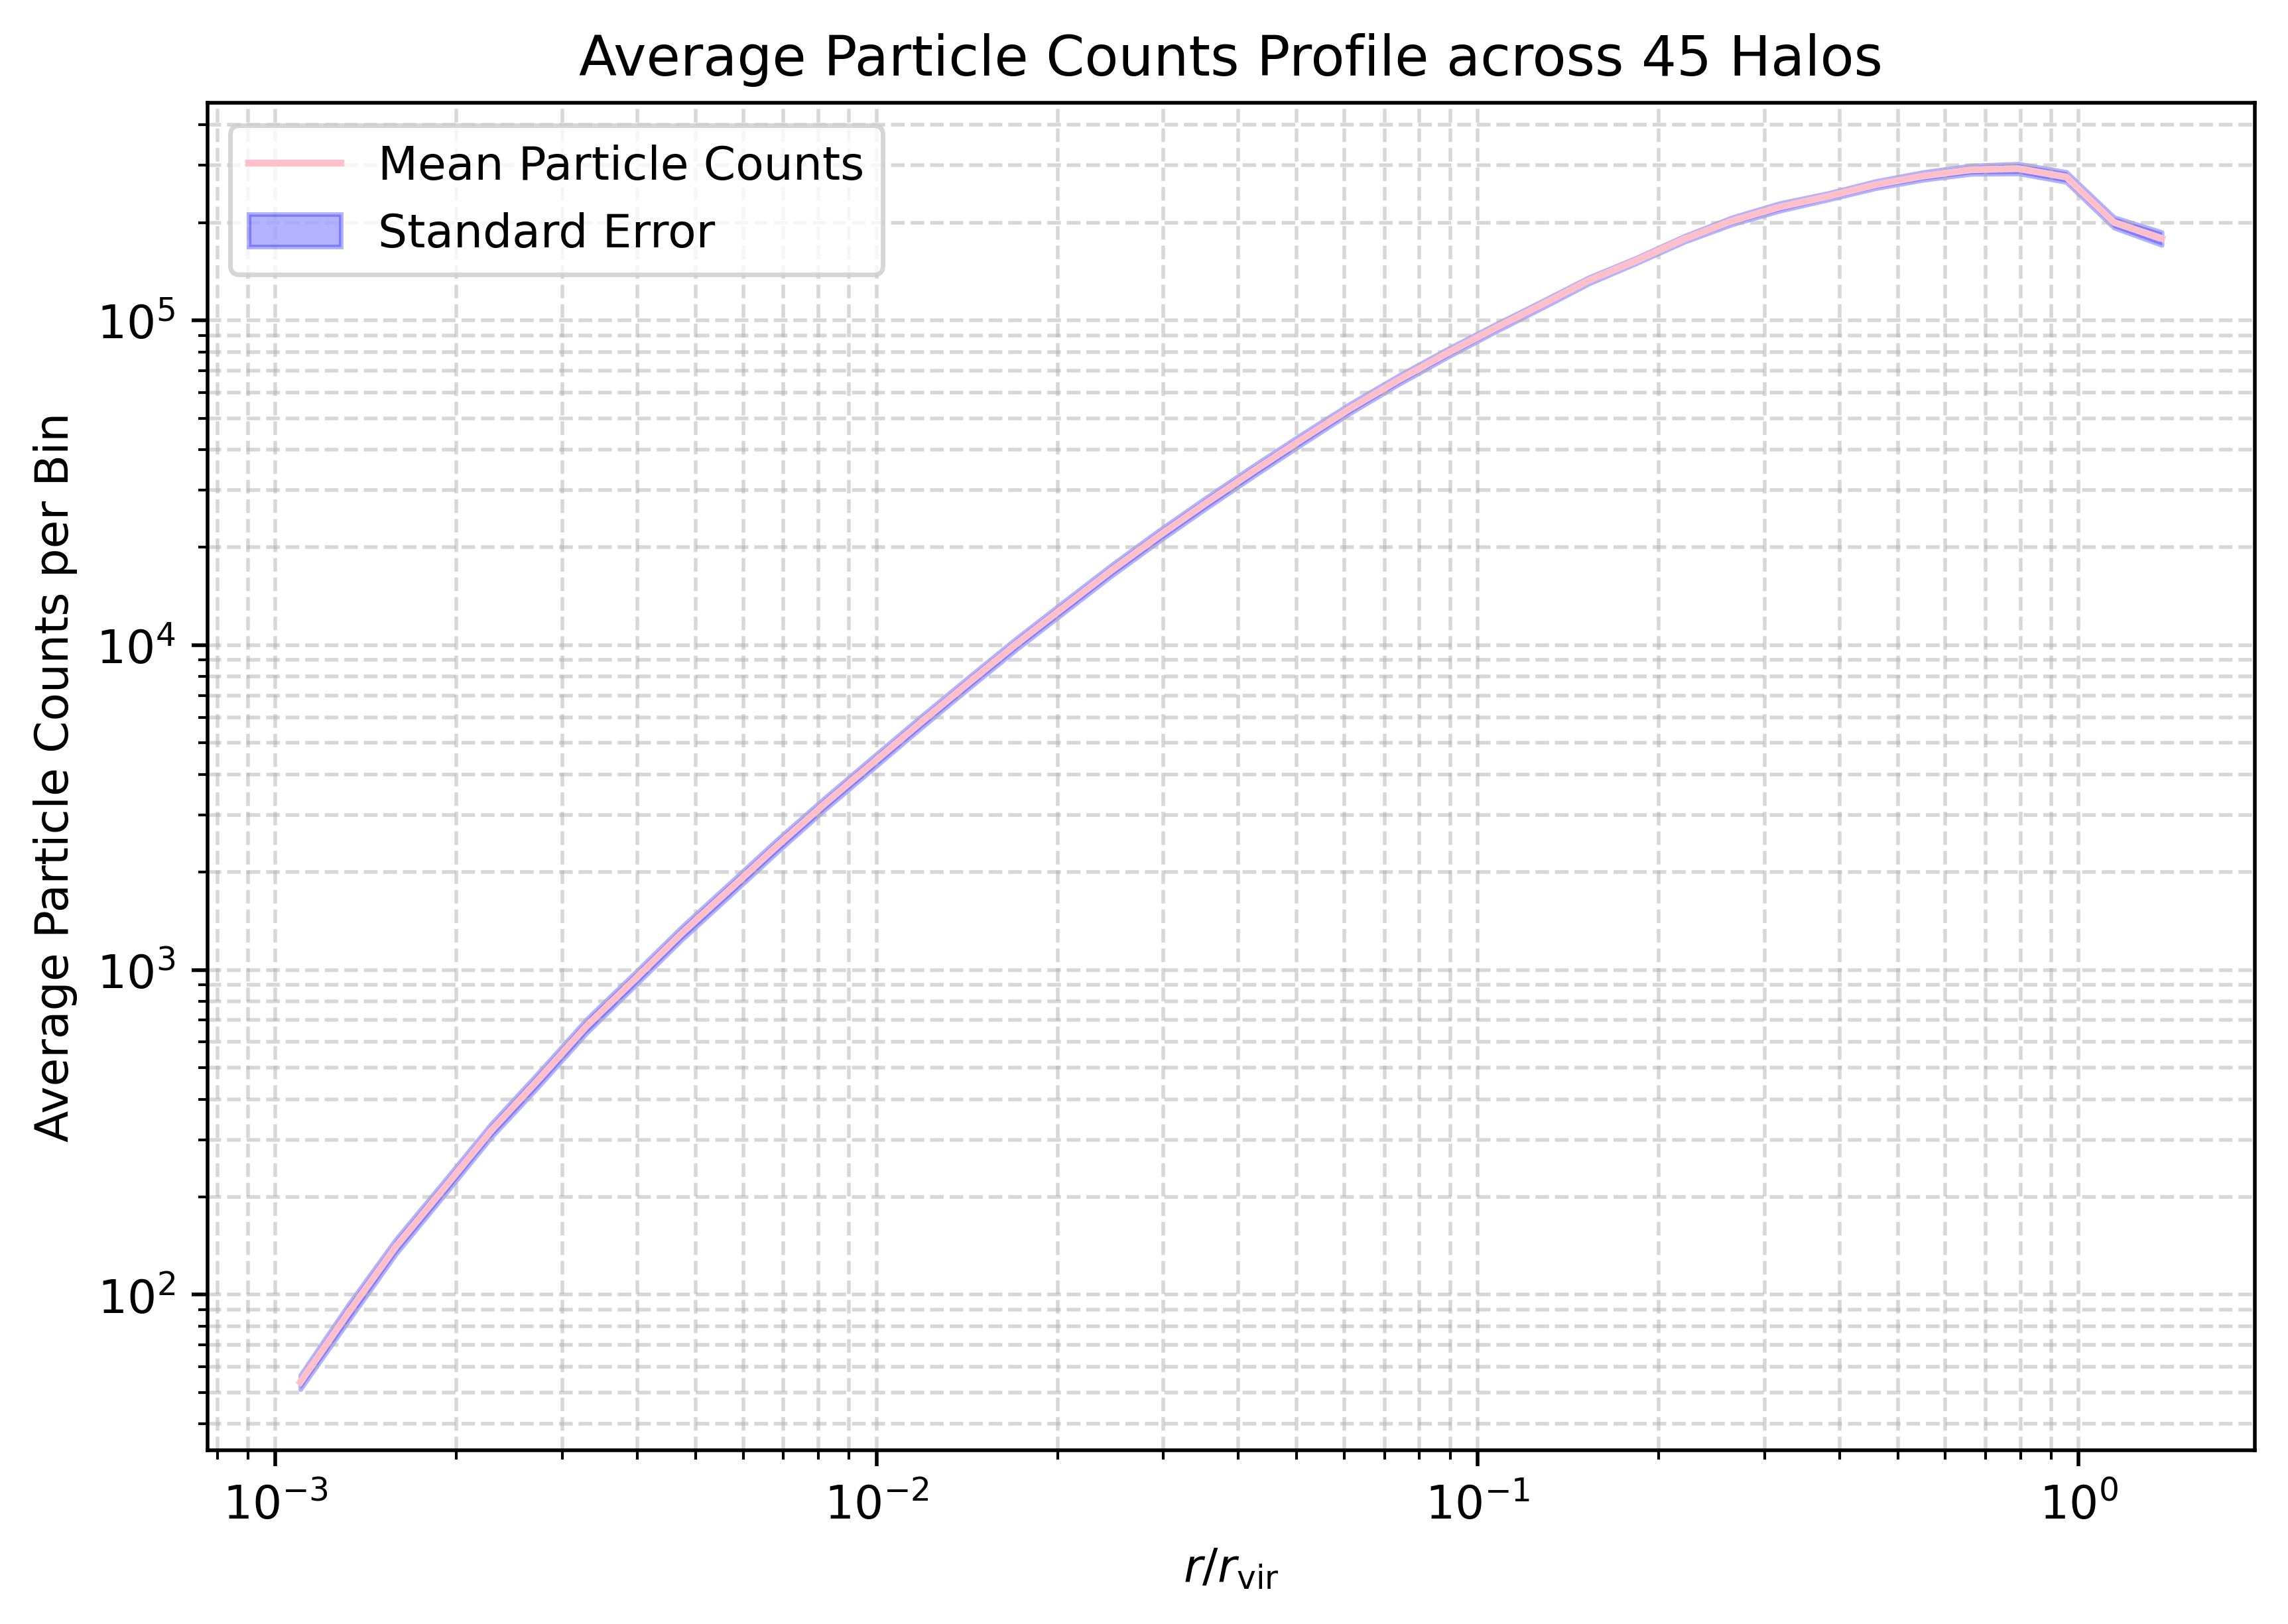

(array([1.10030545e-03, 1.32103871e-03, 1.58605348e-03, 1.90423309e-03,
        2.28624301e-03, 2.74488827e-03, 3.29554277e-03, 3.95666457e-03,
        4.75041461e-03, 5.70339955e-03, 6.84756366e-03, 8.22125956e-03,
        9.87053384e-03, 1.18506705e-02, 1.42280442e-02, 1.70823449e-02,
        2.05092495e-02, 2.46236284e-02, 2.95633967e-02, 3.54941362e-02,
        4.26146468e-02, 5.11636094e-02, 6.14275871e-02, 7.37506306e-02,
        8.85458109e-02, 1.06309066e-01, 1.27635823e-01, 1.53240960e-01,
        1.83982767e-01, 2.20891715e-01, 2.65205000e-01, 3.18408014e-01,
        3.82284132e-01, 4.58974495e-01, 5.51049781e-01, 6.61596373e-01,
        7.94319816e-01, 9.53669028e-01, 1.14498543e+00, 1.37468199e+00]),
 array([5.38222222e+01, 8.78888889e+01, 1.40711111e+02, 2.11933333e+02,
        3.20644444e+02, 4.61911111e+02, 6.73244444e+02, 9.33533333e+02,
        1.30146667e+03, 1.77235556e+03, 2.41991111e+03, 3.26268889e+03,
        4.34666667e+03, 5.78766667e+03, 7.65648889e+03, 1.0089

In [20]:
def average_particle_counts_profile(base_dir, suite_name, snap, n_bins=40, r_min=0.001, r_max=1.5):
    """
    Compute the average radial distribution of particle counts across all host halos
    in a simulation suite, normalized by the host halo's virial radius.
    """

    # Get total number of host halos
    n_halos = symlib.n_hosts(suite_name)
    all_counts = []

    # Define radial bin edges and centers (uniform across all halos)
    bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for halo_idx in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)

        # Load halo center and R_vir from Rockstar catalog
        try:
            r, hist = symlib.read_rockstar(sim_dir)
            host = r[0, -1]
        except FileNotFoundError:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}, skipped.")
            continue

        center = host['x'][-1]       # Halo center [kpc]
        r_vir = host['rvir']         # Virial radius [kpc]

        # Load particle data
        part = symlib.Particles(sim_dir)
        try:
            p = part.read(snap)
        except FileNotFoundError:
            print(f"[Warning] Particle snapshot not found for Halo {halo_idx}, skipped.")
            continue

        x = p[0]['x']
        dx = x - center
        radi = np.linalg.norm(dx, axis=1)        # Distance from halo center [kpc]
        radi_scaled = radi / r_vir               # Normalize radius by R_vir

        # Bin particles by scaled radius
        counts, _ = np.histogram(radi_scaled, bins=bins)
        all_counts.append(counts)

    if len(all_counts) == 0:
        raise RuntimeError("No halo data available for particle count statistics.")

    all_counts = np.array(all_counts)            # (n_halos, n_bins)
    mean_counts = np.mean(all_counts, axis=0)    # Mean across halos
    stderr_counts = np.std(all_counts, axis=0) / np.sqrt(all_counts.shape[0])  # Standard error

    plt.figure(figsize=(7, 5),dpi=500)
    plt.plot(bin_centers, mean_counts, label='Mean Particle Counts', color='pink')
    plt.fill_between(bin_centers, mean_counts - stderr_counts, mean_counts + stderr_counts,
                    color='blue', alpha=0.3, label='Standard Error')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r"$r / r_{\mathrm{vir}}$")
    plt.ylabel("Average Particle Counts per Bin")
    plt.title(f"Average Particle Counts Profile across {len(all_counts)} Halos")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return bin_centers, mean_counts, stderr_counts

average_particle_counts_profile(base_dir="/Volumes/Atlas/Symphony",
                                suite_name="SymphonyMilkyWay",
                                snap=235,
                                n_bins=40,
                                r_min=0.001,
                                r_max=1.5)

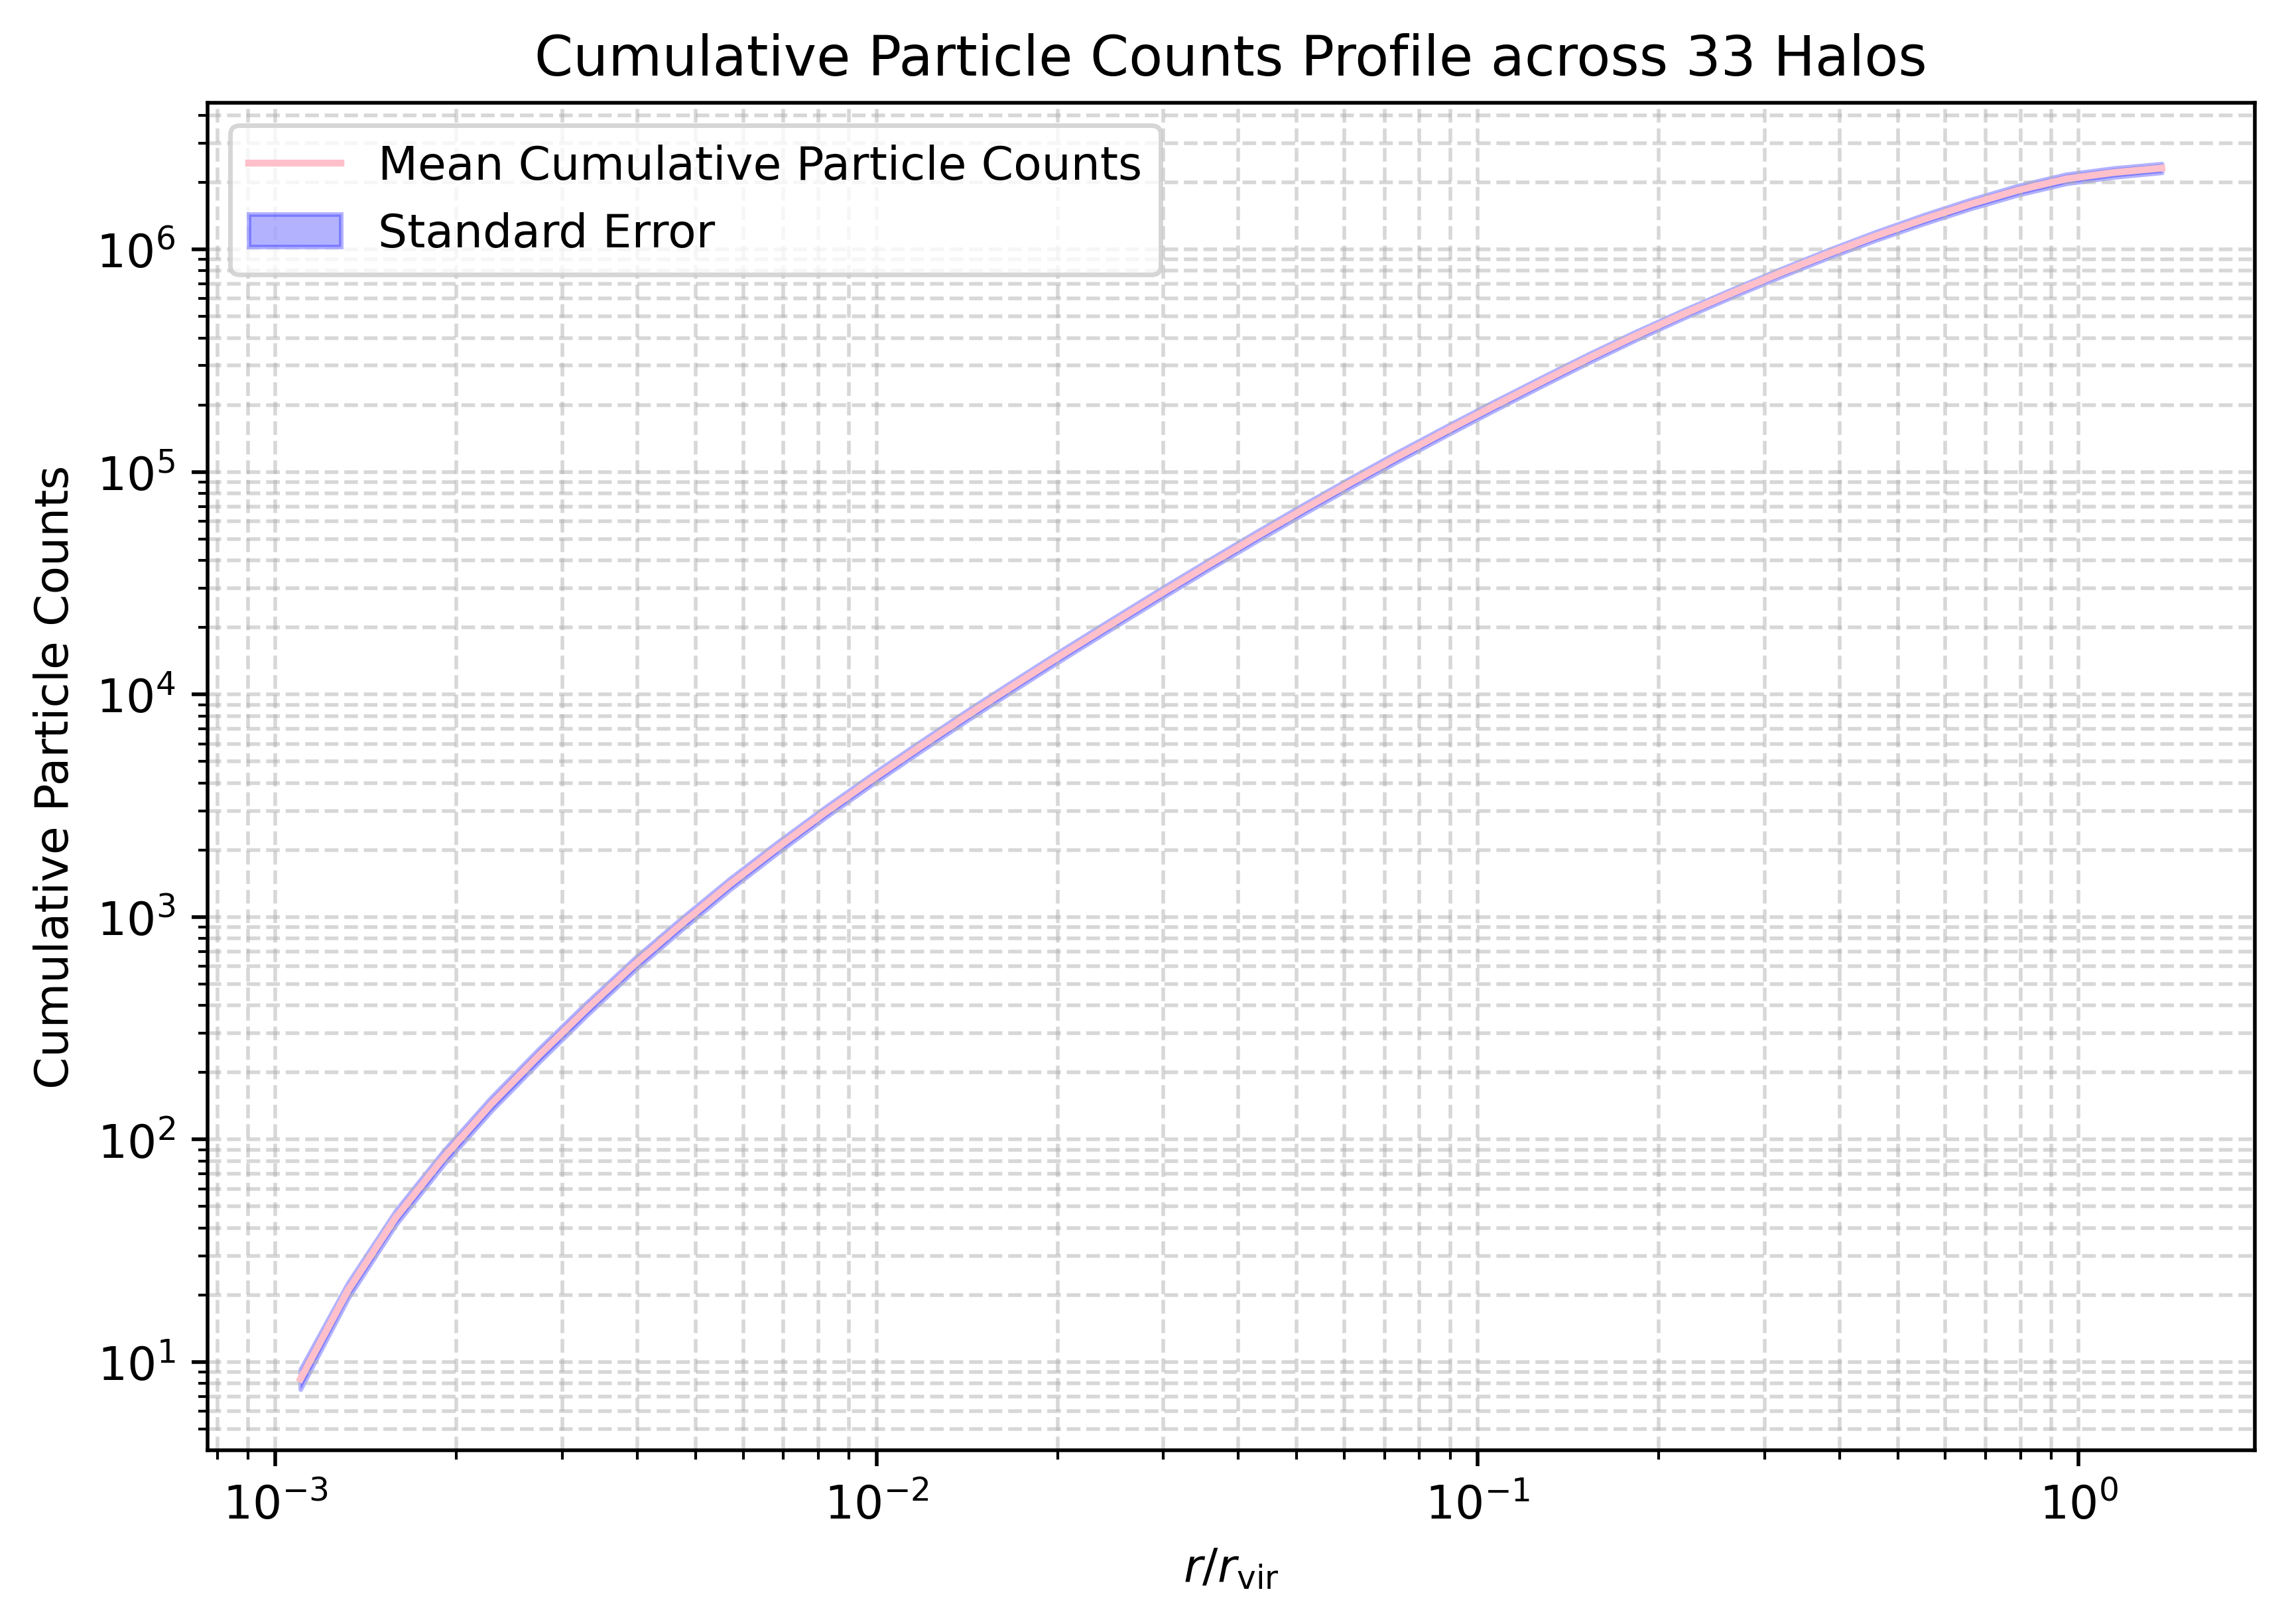

(array([1.10030545e-03, 1.32103871e-03, 1.58605348e-03, 1.90423309e-03,
        2.28624301e-03, 2.74488827e-03, 3.29554277e-03, 3.95666457e-03,
        4.75041461e-03, 5.70339955e-03, 6.84756366e-03, 8.22125956e-03,
        9.87053384e-03, 1.18506705e-02, 1.42280442e-02, 1.70823449e-02,
        2.05092495e-02, 2.46236284e-02, 2.95633967e-02, 3.54941362e-02,
        4.26146468e-02, 5.11636094e-02, 6.14275871e-02, 7.37506306e-02,
        8.85458109e-02, 1.06309066e-01, 1.27635823e-01, 1.53240960e-01,
        1.83982767e-01, 2.20891715e-01, 2.65205000e-01, 3.18408014e-01,
        3.82284132e-01, 4.58974495e-01, 5.51049781e-01, 6.61596373e-01,
        7.94319816e-01, 9.53669028e-01, 1.14498543e+00, 1.37468199e+00]),
 array([8.39393939e+00, 2.10303030e+01, 4.46666667e+01, 8.29393939e+01,
        1.44515152e+02, 2.39121212e+02, 3.86575758e+02, 6.12575758e+02,
        9.35575758e+02, 1.40581818e+03, 2.05412121e+03, 2.95566667e+03,
        4.18396970e+03, 5.85321212e+03, 8.12342424e+03, 1.1162

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def cumulative_particle_counts_profile(base_dir, suite_name, snap, n_bins=40, r_min=0.001, r_max=1.5):
    """
    Compute the cumulative radial distribution of particle counts across all host halos
    in a simulation suite, normalized by the host halo's virial radius.
    """

    # Get total number of host halos
    n_halos = symlib.n_hosts(suite_name)
    all_counts = []

    # Define radial bin edges and centers (uniform across all halos)
    bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for halo_idx in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)

        # Load halo center and R_vir from Rockstar catalog
        try:
            r, hist = symlib.read_rockstar(sim_dir)
            host = r[0, -1]
        except FileNotFoundError:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}, skipped.")
            continue

        center = host['x'][-1]       # Halo center [kpc]
        r_vir = host['rvir']         # Virial radius [kpc]

        # Load particle data
        part = symlib.Particles(sim_dir)
        try:
            p = part.read(snap)
        except FileNotFoundError:
            print(f"[Warning] Particle snapshot not found for Halo {halo_idx}, skipped.")
            continue

        x = p[0]['x']
        dx = x - center
        radi = np.linalg.norm(dx, axis=1)        # Distance from halo center [kpc]
        radi_scaled = radi / r_vir               # Normalize radius by R_vir

        # Bin particles by scaled radius
        counts, _ = np.histogram(radi_scaled, bins=bins)

        # Compute the cumulative sum of counts for each radius bin
        cumulative_counts = np.cumsum(counts)
        all_counts.append(cumulative_counts)

    if len(all_counts) == 0:
        raise RuntimeError("No halo data available for cumulative particle count statistics.")

    all_counts = np.array(all_counts)            # (n_halos, n_bins)
    mean_counts = np.mean(all_counts, axis=0)    # Mean across halos
    stderr_counts = np.std(all_counts, axis=0) / np.sqrt(all_counts.shape[0])  # Standard error

    plt.figure(figsize=(7, 5), dpi=500)
    plt.plot(bin_centers, mean_counts, label='Mean Cumulative Particle Counts', color='pink')
    plt.fill_between(bin_centers, mean_counts - stderr_counts, mean_counts + stderr_counts,
                     color='blue', alpha=0.3, label='Standard Error')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r"$r / r_{\mathrm{vir}}$")
    plt.ylabel("Cumulative Particle Counts")
    plt.title(f"Cumulative Particle Counts Profile across {len(all_counts)} Halos")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return bin_centers, mean_counts, stderr_counts
cumulative_particle_counts_profile(base_dir="/Volumes/Atlas/Symphony",
                                    suite_name="SymphonyLCluster",
                                    snap=199,
                                    n_bins=40,
                                    r_min=0.001,
                                    r_max=1.5)

In [ ]:
output_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"

#density_profile('/Volumes/Atlas/Symphony', 'SymphonyLMC', output_dir, snap=235, n_bins=40, r_min=1e-3, r_max=1.5)
#density_profile('/Volumes/Atlas/Symphony', 'SymphonyMilkyWay', output_dir, snap=235, n_bins=40, r_min=1e-3, r_max=1.5)
#density_profile('/Volumes/Expansion/Symphony', 'SymphonyGroup', output_dir, snap=235, n_bins=40, r_min=1e-3, r_max=1.5)
#density_profile('/Volumes/Atlas/Symphony', 'SymphonyLCluster', output_dir, snap=199, n_bins=40, r_min=1e-3, r_max=1.5)
#density_profile('/Volumes/Expansion/Symphony', 'SymphonyCluster', output_dir, snap=199, n_bins=40, r_min=1e-3, r_max=1.5)

#velocity_profile('/Volumes/Atlas/Symphony', 'SymphonyLMC', output_dir, snap=235, n_bins=40, r_min=1e-3, r_max=1.5)
#velocity_profile('/Volumes/Atlas/Symphony', 'SymphonyMilkyWay', output_dir, snap=235, n_bins=40, r_min=1e-3, r_max=1.5)
#velocity_profile('/Volumes/Expansion/Symphony', 'SymphonyGroup', output_dir, snap=235, n_bins=40, r_min=1e-3, r_max=1.5)
#velocity_profile('/Volumes/Atlas/Symphony', 'SymphonyLCluster', output_dir, snap=199, n_bins=40, r_min=1e-3, r_max=1.5)
#velocity_profile('/Volumes/Expansion/Symphony', 'SymphonyCluster', output_dir, snap=199, n_bins=40, r_min=1e-3, r_max=1.5)

#mass_profile('/Volumes/Atlas/Symphony', 'SymphonyLMC', output_dir, snap=235, n_bins=40, r_min=1e-3, r_max=1.5)
#mass_profile('/Volumes/Atlas/Symphony', 'SymphonyMilkyWay', output_dir, snap=235, n_bins=40, r_min=1e-3, r_max=1.5)
#mass_profile('/Volumes/Expansion/Symphony', 'SymphonyGroup', output_dir, snap=235, n_bins=40, r_min=1e-3, r_max=1.5)
#mass_profile('/Volumes/Atlas/Symphony', 'SymphonyLCluster', output_dir, snap=199, n_bins=40, r_min=1e-3, r_max=1.5)
mass_profile('/Volumes/Expansion/Symphony', 'SymphonyCluster', output_dir, snap=199, n_bins=40, r_min=1e-3, r_max=1.5)

In [ ]:
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"

#plot_density(base_dir, 'SymphonyLMC', mean_cvir=12.3)
#plot_density(base_dir, 'SymphonyMilkyWay', mean_cvir=10.8)
#plot_density(base_dir, 'SymphonyGroup', mean_cvir=8.99)
#plot_density(base_dir, 'SymphonyLCluster', mean_cvir=5.8)
plot_density(base_dir, 'SymphonyCluster', mean_cvir=5.6)

In [ ]:
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"

#plot_velocity(base_dir, 'SymphonyLMC', mean_cvir=12.3, )
#plot_velocity(base_dir, 'SymphonyMilkyWay', mean_cvir=10.8)
#plot_velocity(base_dir, 'SymphonyGroup', mean_cvir=8.99)
#plot_velocity(base_dir, 'SymphonyLCluster', mean_cvir=5.8)
plot_velocity(base_dir, 'SymphonyCluster', mean_cvir=5.6)